In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd


# Load data
data = pd.read_csv('dataset/ed/finals/16_finalwithsigmoid.csv')

# Initial inspection
print(f"Dataset shape: {data.shape}")
print("\nMissing values per column:")
print(data.isnull().sum())

# Check outcome distribution
print("\nOutcome distribution:")
print(data['died_within_30_days'].value_counts())
print(f"Overall mortality rate: {data['died_within_30_days'].mean()*100:.2f}%")

Dataset shape: (591892, 33)

Missing values per column:
subject_id                      0
stay_id                         0
intime                          0
outtime                         0
gender                          0
race                            0
chiefcomplaint                  0
anchor_age                      0
anchor_year                     0
anchor_year_group               0
dod                        482102
dead_in_days               482102
died_within_30_days             0
race_standard                   0
age_group                       0
unique_visit_id                 0
terms                           0
terms_new                       0
indiv_symptom                   0
counter                         0
unique_ids_exploded             0
expanded_symptoms               0
expanded_symptoms_new           0
counter_new                     0
unique_ids_exploded_new         0
snomed                     347976
is_male                         0
ed_age                    

In [2]:
# ===== Cell 2: cleaning (super simple) =====
def clean_dataset_simple(df, prob_col="mortality_prob", y_col="died_within_30_days"):
    """
    Very simple cleaner:
      1) Show how many rows and how many miss the score/label
      2) Keep only rows that have BOTH
      3) Make sure the score is in [0,1] and the label is 0/1
      4) Print after-cleaning summary
    """
    print("=== CLEANING ===")
    print(f"Rows BEFORE: {len(df):,}")
    miss_prob = int(df[prob_col].isna().sum())
    miss_lbl  = int(df[y_col].isna().sum())
    print(f"Missing {prob_col}: {miss_prob:,}")
    print(f"Missing {y_col}: {miss_lbl:,}")

    # Keep rows that have both a score and a label
    out = df.loc[df[prob_col].notna() & df[y_col].notna()].copy()

    # Make types clean and safe
    out[prob_col] = pd.to_numeric(out[prob_col], errors="coerce").astype(float).clip(0, 1)
    out[y_col]    = pd.to_numeric(out[y_col], errors="coerce").astype(int)

    # Drop any row that became NaN during coercion (rare)
    out = out.dropna(subset=[prob_col, y_col])

    kept = len(out)
    print("\n=== AFTER CLEANING ===")
    print(f"Rows AFTER : {kept:,}  (kept {kept/len(df):.1%} of original)")
    if kept > 0:
        lbl_vals = sorted(pd.Series(out[y_col]).unique().tolist())
        print(f"Label values present: {lbl_vals}")
        print(f"Prevalence (mean of {y_col}): {out[y_col].mean():.4f}")
        print(f"{prob_col}: mean={out[prob_col].mean():.4f}, min={out[prob_col].min():.4f}, max={out[prob_col].max():.4f}")
        print("\nPreview (first 3 rows of score+label):")
        print(out[[prob_col, y_col]].head(3))
    return out

data = clean_dataset_simple(data, prob_col="mortality_prob", y_col="died_within_30_days")

=== CLEANING ===
Rows BEFORE: 591,892
Missing mortality_prob: 358,997
Missing died_within_30_days: 0

=== AFTER CLEANING ===
Rows AFTER : 232,895  (kept 39.3% of original)
Label values present: [0, 1]
Prevalence (mean of died_within_30_days): 0.0222
mortality_prob: mean=0.0163, min=0.0000, max=0.9417

Preview (first 3 rows of score+label):
   mortality_prob  died_within_30_days
0        0.003980                    0
3        0.010333                    0
4        0.002620                    0



Gender distribution:
gender
F    136433
M     96462
Name: count, dtype: int64
gender
F    58.581335
M    41.418665
Name: count, dtype: float64

Race distribution:
race_standard
White                               131424
Black                                53687
Hispanic/Latino                      21868
Other/Unknown/Not Reported           14542
Asian                                10453
American Indian/Alaska Native          546
Native Hawaiian/Pacific Islander       285
Multiple Races                          90
Name: count, dtype: int64
race_standard
White                               56.430580
Black                               23.052019
Hispanic/Latino                      9.389639
Other/Unknown/Not Reported           6.244016
Asian                                4.488289
American Indian/Alaska Native        0.234440
Native Hawaiian/Pacific Islander     0.122373
Multiple Races                       0.038644
Name: count, dtype: float64

Age group distribution:
age_group
46-65  

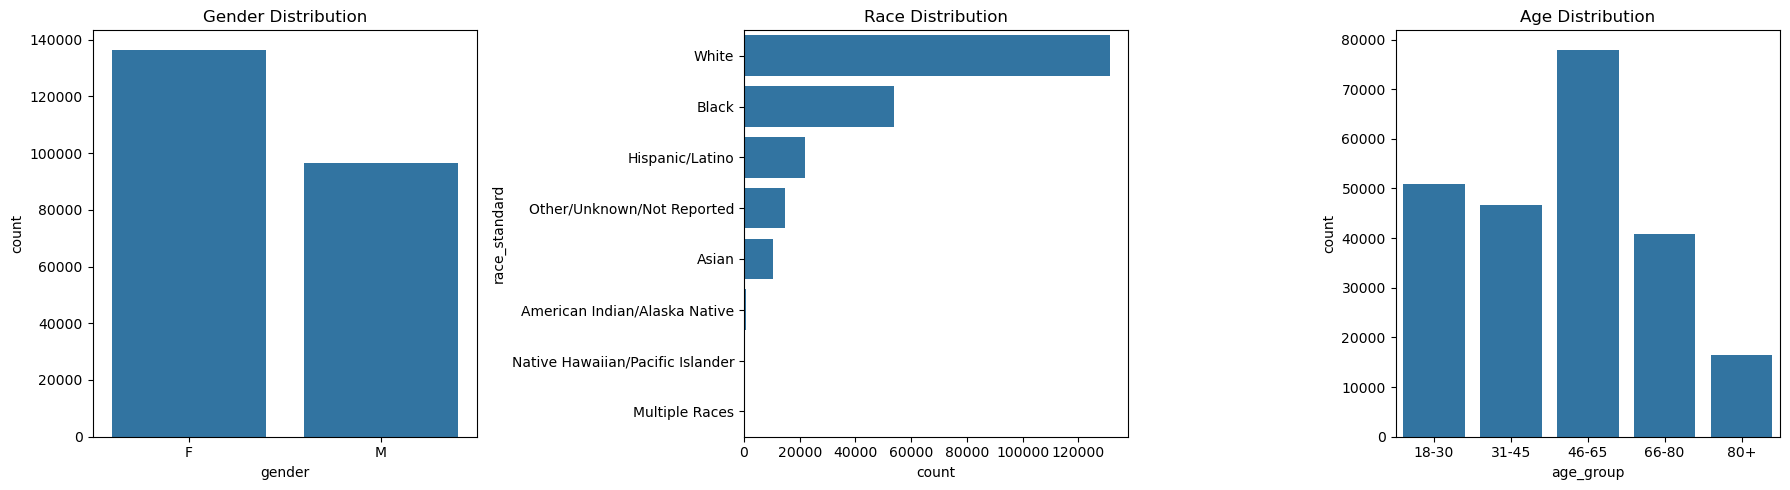

In [3]:
# Check distribution of protected attributes
print("\nGender distribution:")
gender_counts = data['gender'].value_counts()
print(gender_counts)
print(gender_counts / len(data) * 100)

print("\nRace distribution:")
race_counts = data['race_standard'].value_counts()
print(race_counts)
print(race_counts / len(data) * 100)

print("\nAge group distribution:")
age_counts = data['age_group'].value_counts()
print(age_counts)
print(age_counts / len(data) * 100)

# Visualize distributions
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Gender
sns.countplot(x='gender', data=data, ax=axes[0])
axes[0].set_title('Gender Distribution')

# Race
race_order = race_counts.index
sns.countplot(y='race_standard', data=data, order=race_order, ax=axes[1])
axes[1].set_title('Race Distribution')

# Age
age_order = ['18-30', '31-45', '46-65', '66-80', '80+']
sns.countplot(x='age_group', data=data, order=age_order, ax=axes[2])
axes[2].set_title('Age Distribution')

plt.tight_layout()
plt.show()

Mortality rate by gender:
gender
F    1.808214
M    2.805250
Name: died_within_30_days, dtype: float64

Mortality rate by race:
race_standard
American Indian/Alaska Native       0.732601
Asian                               2.343825
Black                               1.272189
Hispanic/Latino                     0.896287
Multiple Races                      0.000000
Native Hawaiian/Pacific Islander    5.263158
Other/Unknown/Not Reported          3.025719
White                               2.731617
Name: died_within_30_days, dtype: float64

Mortality rate by age group:
age_group
18-30    0.117786
31-45    0.520432
46-65    2.104899
66-80    4.374434
80+      8.765425
Name: died_within_30_days, dtype: float64


C:\Users\mitra\AppData\Local\Temp\ipykernel_40924\626453242.py:29: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[1].set_xticklabels(axes[1].get_xticklabels(), rotation=45, ha='right')


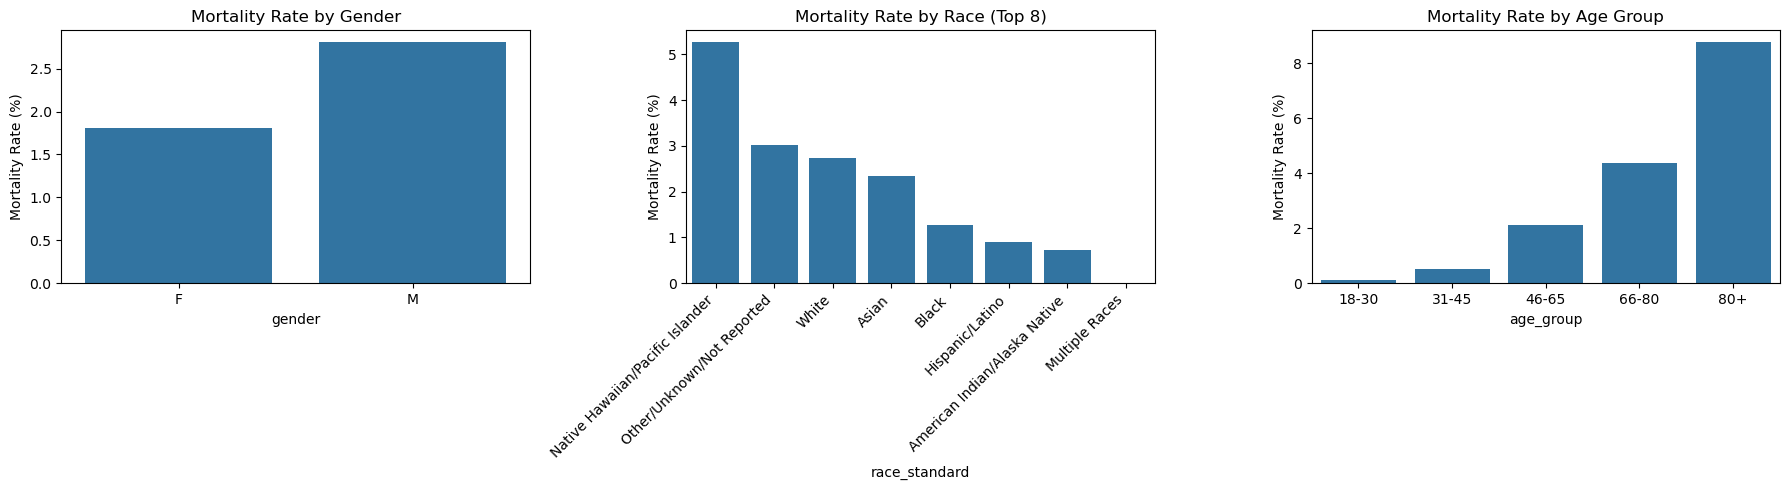

In [7]:
# Mortality by gender
gender_mortality = data.groupby('gender')['died_within_30_days'].mean() * 100
print("Mortality rate by gender:")
print(gender_mortality)

# Mortality by race
race_mortality = data.groupby('race_standard')['died_within_30_days'].mean() * 100
print("\nMortality rate by race:")
print(race_mortality)

# Mortality by age
age_mortality = data.groupby('age_group')['died_within_30_days'].mean() * 100
print("\nMortality rate by age group:")
print(age_mortality)

# Visualize mortality rates
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Gender mortality
sns.barplot(x=gender_mortality.index, y=gender_mortality.values, ax=axes[0])
axes[0].set_title('Mortality Rate by Gender')
axes[0].set_ylabel('Mortality Rate (%)')

# Race mortality (top 8)
race_mort_sorted = race_mortality.sort_values(ascending=False)
sns.barplot(x=race_mort_sorted.index[:8], y=race_mort_sorted.values[:8], ax=axes[1])
axes[1].set_title('Mortality Rate by Race (Top 8)')
axes[1].set_ylabel('Mortality Rate (%)')
axes[1].set_xticklabels(axes[1].get_xticklabels(), rotation=45, ha='right')

# Age mortality
age_mort_df = pd.DataFrame({'age_group': age_mortality.index, 'mortality': age_mortality.values})
age_mort_df['age_group'] = pd.Categorical(age_mort_df['age_group'], categories=age_order, ordered=True)
age_mort_df = age_mort_df.sort_values('age_group')
sns.barplot(x=age_mort_df['age_group'], y=age_mort_df['mortality'], ax=axes[2])
axes[2].set_title('Mortality Rate by Age Group')
axes[2].set_ylabel('Mortality Rate (%)')

plt.tight_layout()
plt.show()


--- Race Distribution Analysis ---
race_standard
White                               131424
Black                                53687
Hispanic/Latino                      21868
Other/Unknown/Not Reported           14542
Asian                                10453
American Indian/Alaska Native          546
Native Hawaiian/Pacific Islander       285
Multiple Races                          90
Name: count, dtype: int64

Race percentages:
White: 56.43%
Black: 23.05%
Hispanic/Latino: 9.39%
Other/Unknown/Not Reported: 6.24%
Asian: 4.49%
American Indian/Alaska Native: 0.23%
Native Hawaiian/Pacific Islander: 0.12%
Multiple Races: 0.04%

--- Mortality Rates by Race ---
race_standard
American Indian/Alaska Native       0.73
Asian                               2.34
Black                               1.27
Hispanic/Latino                     0.90
Multiple Races                      0.00
Native Hawaiian/Pacific Islander    5.26
Other/Unknown/Not Reported          3.03
White                         

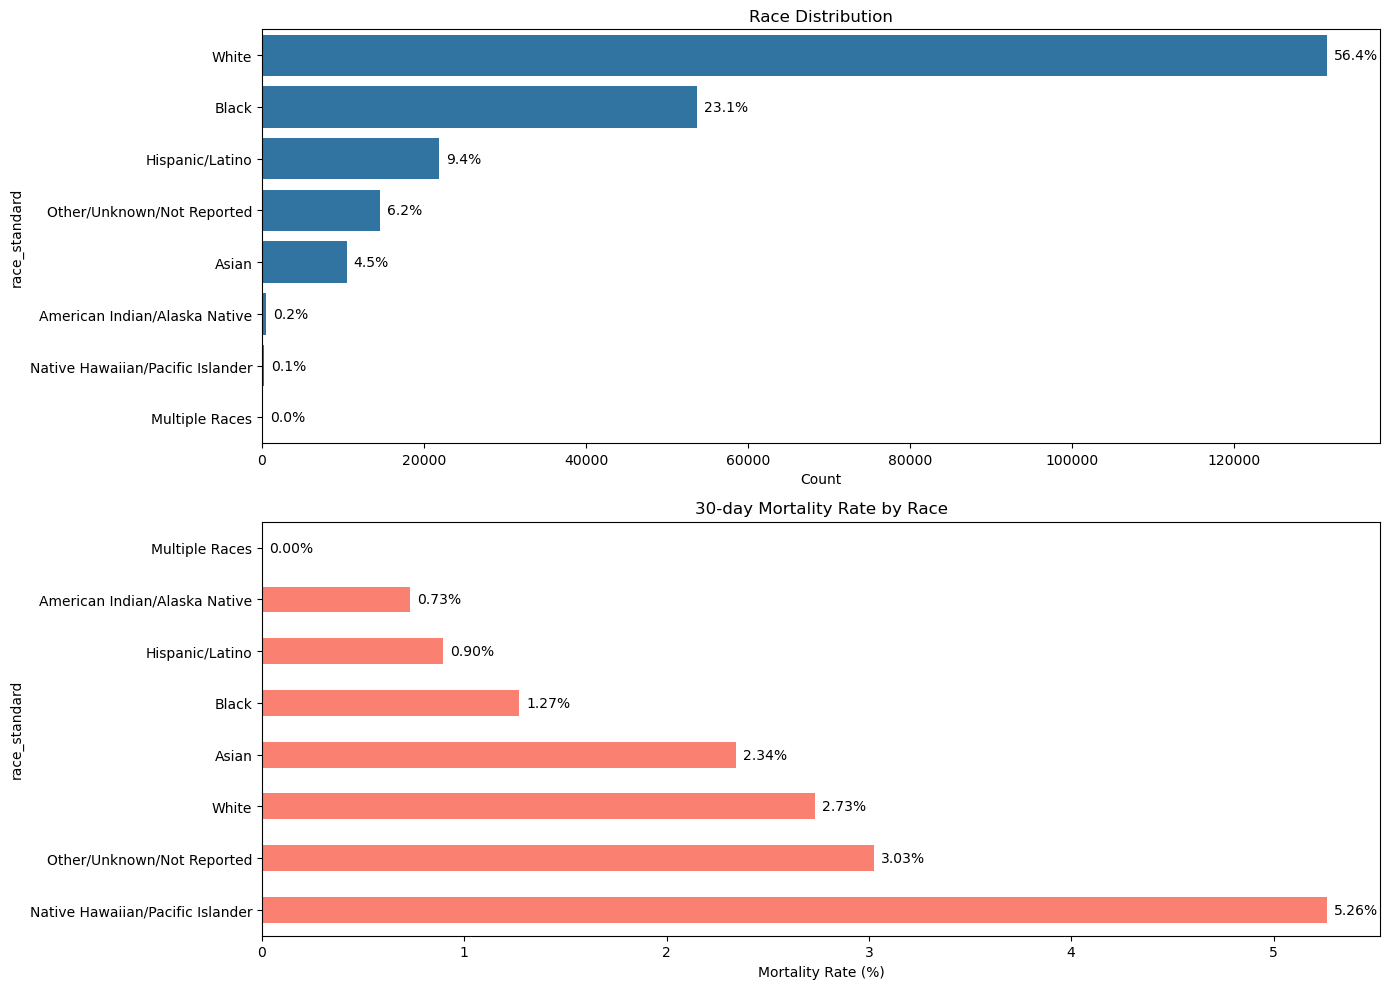


--- Missing SNOMED Code Analysis by Race ---
Missing SNOMED code percentages by race:
race_standard
American Indian/Alaska Native       0.0
Asian                               0.0
Black                               0.0
Hispanic/Latino                     0.0
Multiple Races                      0.0
Native Hawaiian/Pacific Islander    0.0
Other/Unknown/Not Reported          0.0
White                               0.0
Name: symptom, dtype: float64

Missing data disparity ratio: inf
Missing data parity difference: 0.00%


In [26]:
# 1. Analyze race distribution
race_counts = data['race_standard'].value_counts()
race_percentages = race_counts / len(data) * 100

print("\n--- Race Distribution Analysis ---")
print(race_counts)
print(f"\nRace percentages:")
for race, percentage in race_percentages.items():
    print(f"{race}: {percentage:.2f}%")

# 2. Check mortality rates by race
print("\n--- Mortality Rates by Race ---")
mortality_by_race = data.groupby('race_standard')['died_within_30_days'].mean() * 100
print(mortality_by_race)

# Calculate statistical parity difference (max - min) and disparate impact ratio (min/max)
max_mortality_race = mortality_by_race.max()
min_mortality_race = mortality_by_race.min()
stat_parity_diff = max_mortality_race - min_mortality_race
disparate_impact = min_mortality_race / max_mortality_race

print(f"\nStatistical parity difference: {stat_parity_diff:.2f}%")
print(f"Disparate impact ratio: {disparate_impact:.2f}")
print(f"Disparate impact concern: {disparate_impact < 0.8}")  # Common threshold

# 3. Visualize race distribution and mortality rates
plt.figure(figsize=(14, 10))

# Race distribution 
plt.subplot(2, 1, 1)
sns.countplot(y='race_standard', data=data, order=race_counts.index)
plt.title('Race Distribution')
plt.xlabel('Count')

# Add percentage labels
for i, count in enumerate(race_counts):
    plt.annotate(f"{race_percentages.iloc[i]:.1f}%", 
                xy=(count, i), 
                xytext=(5, 0),
                textcoords='offset points',
                va='center')

# Mortality rates by race
plt.subplot(2, 1, 2)
mortality_by_race.sort_values(ascending=False).plot(kind='barh', color='salmon')
plt.title('30-day Mortality Rate by Race')
plt.xlabel('Mortality Rate (%)')

# Add percentage labels
for i, rate in enumerate(mortality_by_race.sort_values(ascending=False)):
    plt.annotate(f"{rate:.2f}%", 
                xy=(rate, i), 
                xytext=(5, 0),
                textcoords='offset points',
                va='center')

plt.tight_layout()
plt.show()

# 4. Check if missing values in symptom are biased by race
print("\n--- Missing SNOMED Code Analysis by Race ---")
# Fixed code using apply with a lambda function
missing_by_race = data.groupby('race_standard')['symptom'].apply(lambda x: x.isnull().mean() * 100)
print(f"Missing SNOMED code percentages by race:")
print(missing_by_race)

# Calculate disparity ratio for missing data
max_missing = missing_by_race.max()
min_missing = missing_by_race.min()
disparity_ratio = max_missing / min_missing if min_missing > 0 else float('inf')
print(f"\nMissing data disparity ratio: {disparity_ratio:.2f}")
print(f"Missing data parity difference: {max_missing - min_missing:.2f}%")


--- Age Group Distribution Analysis ---
age_group
46-65    77961
18-30    50940
31-45    46692
66-80    40851
80+      16451
Name: count, dtype: int64

Age group percentages:
46-65: 33.47%
18-30: 21.87%
31-45: 20.05%
66-80: 17.54%
80+: 7.06%

--- Mortality Rates by Age Group ---
age_group
18-30    0.12
31-45    0.52
46-65    2.10
66-80    4.37
80+      8.77
Name: died_within_30_days, dtype: float64


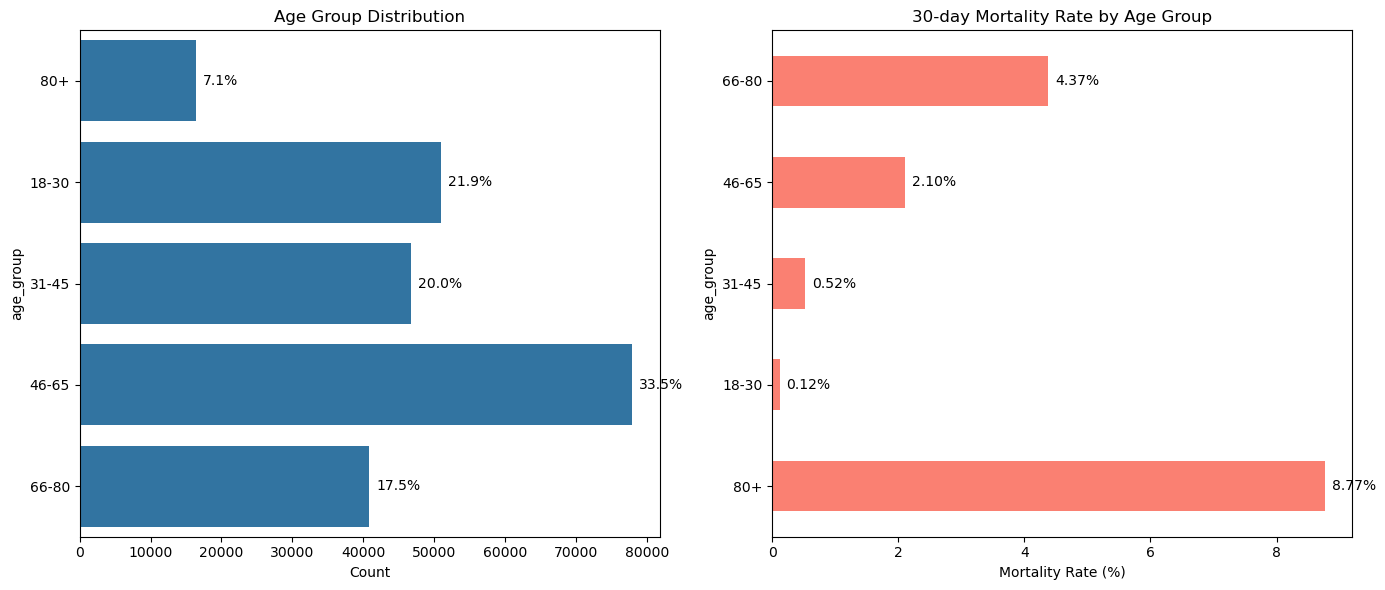


Statistical parity difference: 8.65%
Disparate impact ratio: 0.01
Disparate impact concern: True


In [28]:
# 1. Analyze age group distribution
age_counts = data['age_group'].value_counts()
age_percentages = age_counts / len(data) * 100

print("\n--- Age Group Distribution Analysis ---")
print(age_counts)
print(f"\nAge group percentages:")
for age, percentage in age_percentages.items():
    print(f"{age}: {percentage:.2f}%")

# 2. Check mortality rates by age group
print("\n--- Mortality Rates by Age Group ---")
mortality_by_age = data.groupby('age_group')['died_within_30_days'].mean() * 100
print(mortality_by_age)

# 3. Visualize age distribution and mortality rates
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Order age groups properly (assuming they are like '18-25', '26-45', etc.)
# This tries to sort them naturally, but adjust if needed
age_order = sorted(data['age_group'].unique(), 
                   key=lambda x: int(x.split('-')[0]) if '-' in x else 0)

# Age distribution
sns.countplot(y='age_group', data=data, order=age_order, ax=axes[0])
axes[0].set_title('Age Group Distribution')
axes[0].set_xlabel('Count')

# Add percentage labels
for i, age in enumerate(age_order):
    count = age_counts.get(age, 0)
    percentage = age_percentages.get(age, 0)
    axes[0].annotate(f"{percentage:.1f}%", 
                  xy=(count, i), 
                  xytext=(5, 0),
                  textcoords='offset points',
                  va='center')

# Mortality rates by age
mortality_by_age_sorted = mortality_by_age.loc[age_order]
mortality_by_age_sorted.plot(kind='barh', ax=axes[1], color='salmon')
axes[1].set_title('30-day Mortality Rate by Age Group')
axes[1].set_xlabel('Mortality Rate (%)')

# Add percentage labels
for i, age in enumerate(age_order):
    rate = mortality_by_age.get(age, 0)
    axes[1].annotate(f"{rate:.2f}%", 
                  xy=(rate, i), 
                  xytext=(5, 0),
                  textcoords='offset points',
                  va='center')

plt.tight_layout()
plt.show()

# Calculate statistical parity difference and disparate impact
max_mortality_age = mortality_by_age.max()
min_mortality_age = mortality_by_age.min()
stat_parity_diff = max_mortality_age - min_mortality_age
disparate_impact = min_mortality_age / max_mortality_age

print(f"\nStatistical parity difference: {stat_parity_diff:.2f}%")
print(f"Disparate impact ratio: {disparate_impact:.2f}")
print(f"Disparate impact concern: {disparate_impact < 0.8}")

Sampling: [female_theta, male_theta]



--- Bayesian Prior Analysis ---
Prior belief about mortality rate differences between genders:
Mean difference (Male - Female): 0.000061
95% Prior Credible Interval: (-0.164929, 0.172212)


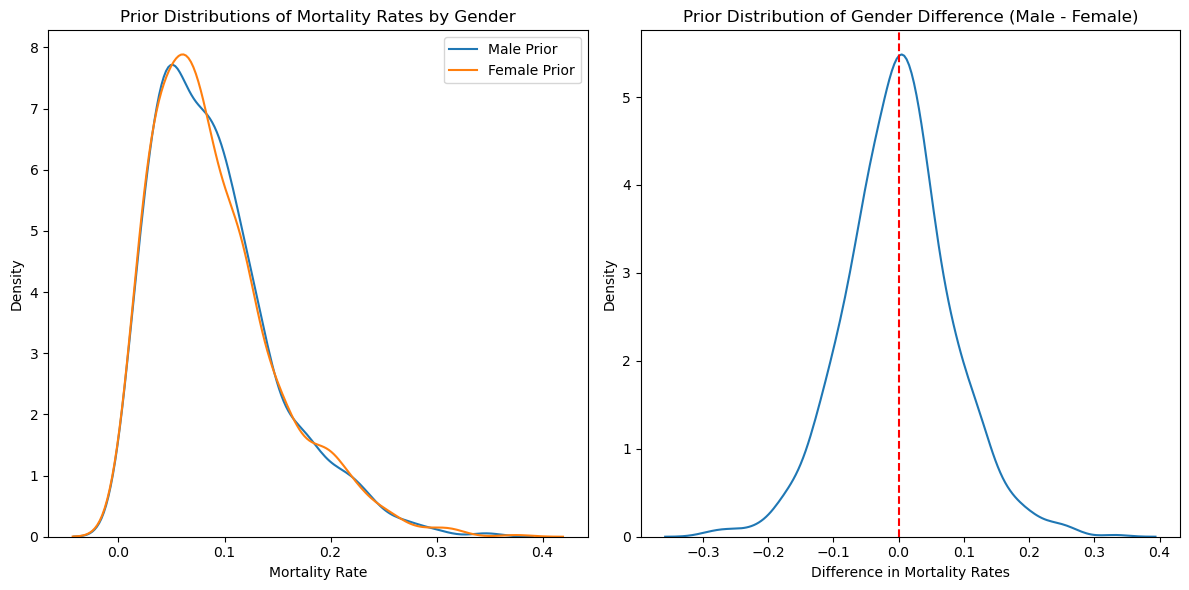


Key takeaway: If our prior distributions have means or variances that differ by protected group,
we may be encoding bias before even seeing the data.


In [30]:
# Step 4: For Bayesian analysis we'll use PyMC (newer version of PyMC3)
import pymc as pm
import arviz as az

# Let's analyze if our prior beliefs might encode bias
print("\n--- Bayesian Prior Analysis ---")

# Create a simplified dataset for analysis (using a small random sample for performance)
# In practice, you'd use a larger, representative sample
np.random.seed(42)
sample_idx = np.random.choice(len(data), size=10000, replace=False)
sample_data = data.iloc[sample_idx].copy()

# Define prior distributions for different groups to check for bias
with pm.Model() as gender_prior_model:
    # Define priors for mortality by gender
    male_theta = pm.Beta('male_theta', alpha=2, beta=20)  # weak prior centered around ~0.09
    female_theta = pm.Beta('female_theta', alpha=2, beta=20)  # same prior
    
    # Calculate the difference in mortality rates
    difference = pm.Deterministic('difference', male_theta - female_theta)
    
    # Sample from prior (no observed data yet)
    gender_prior_trace = pm.sample_prior_predictive(1000)

# Analyze the prior's inherent beliefs about gender differences
male_prior = gender_prior_trace.prior['male_theta'].values
female_prior = gender_prior_trace.prior['female_theta'].values
diff_prior = gender_prior_trace.prior['difference'].values

# Flatten arrays for easier analysis
male_prior = male_prior.flatten()
female_prior = female_prior.flatten()
diff_prior = diff_prior.flatten()

print("Prior belief about mortality rate differences between genders:")
print(f"Mean difference (Male - Female): {diff_prior.mean():.6f}")
print(f"95% Prior Credible Interval: ({np.percentile(diff_prior, 2.5):.6f}, {np.percentile(diff_prior, 97.5):.6f})")

# Visualize the prior distributions
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
sns.kdeplot(male_prior, label='Male Prior')
sns.kdeplot(female_prior, label='Female Prior')
plt.title('Prior Distributions of Mortality Rates by Gender')
plt.xlabel('Mortality Rate')
plt.legend()

plt.subplot(1, 2, 2)
sns.kdeplot(diff_prior)
plt.axvline(x=0, color='red', linestyle='--')
plt.title('Prior Distribution of Gender Difference (Male - Female)')
plt.xlabel('Difference in Mortality Rates')

plt.tight_layout()
plt.show()

print("\nKey takeaway: If our prior distributions have means or variances that differ by protected group,")
print("we may be encoding bias before even seeing the data.")

In [31]:
# Chi-square tests for associations with outcome
print("Statistical significance tests:")

# Gender
gender_crosstab = pd.crosstab(data['gender'], data['died_within_30_days'])
chi2_gender, p_gender, _, _ = stats.chi2_contingency(gender_crosstab)
print(f"Gender association: Chi2 = {chi2_gender:.4f}, p = {p_gender:.8f}")
print(f"Statistically significant: {p_gender < 0.05}")

# Race
race_crosstab = pd.crosstab(data['race_standard'], data['died_within_30_days'])
chi2_race, p_race, _, _ = stats.chi2_contingency(race_crosstab)
print(f"\nRace association: Chi2 = {chi2_race:.4f}, p = {p_race:.8f}")
print(f"Statistically significant: {p_race < 0.05}")

# Age
age_crosstab = pd.crosstab(data['age_group'], data['died_within_30_days'])
chi2_age, p_age, _, _ = stats.chi2_contingency(age_crosstab)
print(f"\nAge association: Chi2 = {chi2_age:.4f}, p = {p_age:.8f}")
print(f"Statistically significant: {p_age < 0.05}")

Statistical significance tests:
Gender association: Chi2 = 258.1898, p = 0.00000000
Statistically significant: True

Race association: Chi2 = 620.8507, p = 0.00000000
Statistically significant: True

Age association: Chi2 = 5780.5456, p = 0.00000000
Statistically significant: True


In [33]:
# Calculate common fairness metrics

# Statistical Parity Difference
print("\nStatistical Parity Difference (absolute difference in outcomes):")
gender_spd = abs(gender_mortality.max() - gender_mortality.min()) / 100
race_spd = abs(race_mortality.max() - race_mortality.min()) / 100
age_spd = abs(age_mortality.max() - age_mortality.min()) / 100

print(f"Gender: {gender_spd:.4f}")
print(f"Race: {race_spd:.4f}")
print(f"Age: {age_spd:.4f}")

# Disparate Impact Ratio (min/max outcome rate)
print("\nDisparate Impact Ratio (min/max outcome rate):")
gender_dir = gender_mortality.min() / gender_mortality.max()
race_dir = race_mortality.min() / race_mortality.max()
age_dir = age_mortality.min() / age_mortality.max()

print(f"Gender: {gender_dir:.4f} (Below 0.8 threshold: {gender_dir < 0.8})")
print(f"Race: {race_dir:.4f} (Below 0.8 threshold: {race_dir < 0.8})")
print(f"Age: {age_dir:.4f} (Below 0.8 threshold: {age_dir < 0.8})")


Statistical Parity Difference (absolute difference in outcomes):
Gender: 0.0100
Race: 0.0526
Age: 0.0865

Disparate Impact Ratio (min/max outcome rate):
Gender: 0.6446 (Below 0.8 threshold: True)
Race: 0.0000 (Below 0.8 threshold: True)
Age: 0.0134 (Below 0.8 threshold: True)


Mortality rates by race and gender:
gender                               F     M
race_standard                               
American Indian/Alaska Native     0.32  1.28
Asian                             1.46  3.63
Black                             1.14  1.53
Hispanic/Latino                   0.66  1.32
Multiple Races                    0.00  0.00
Native Hawaiian/Pacific Islander  2.10  8.45
Other/Unknown/Not Reported        2.43  3.85
White                             2.32  3.23

Mortality rates by age and gender:
gender        F      M
age_group             
80+        7.74  10.41
18-30      0.08   0.20
31-45      0.37   0.76
46-65      1.67   2.60
66-80      3.86   4.99


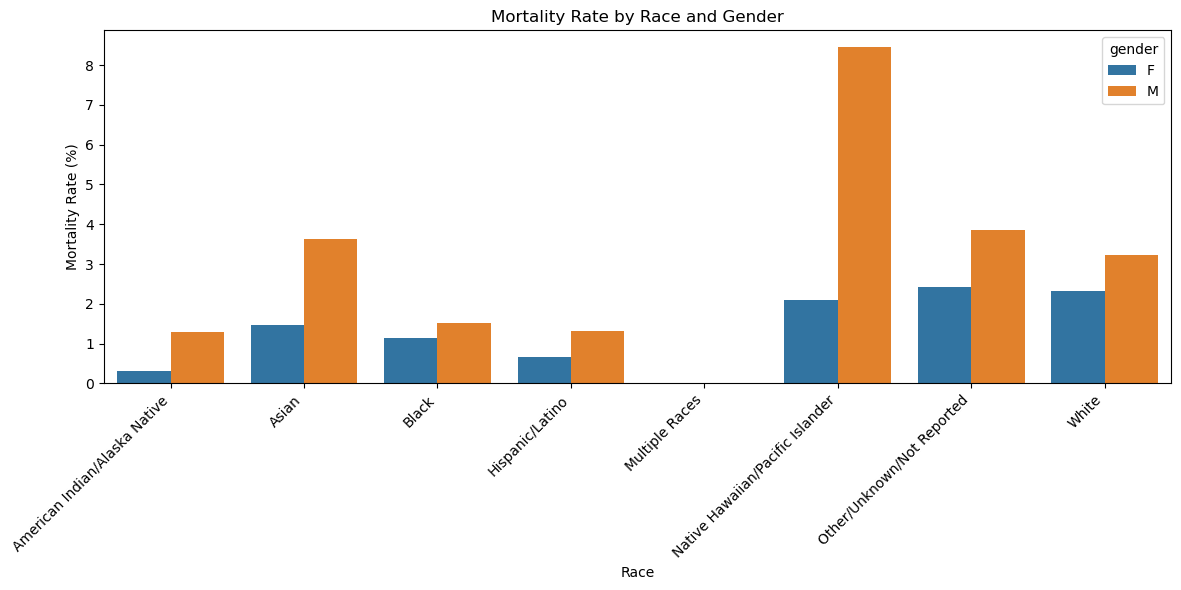

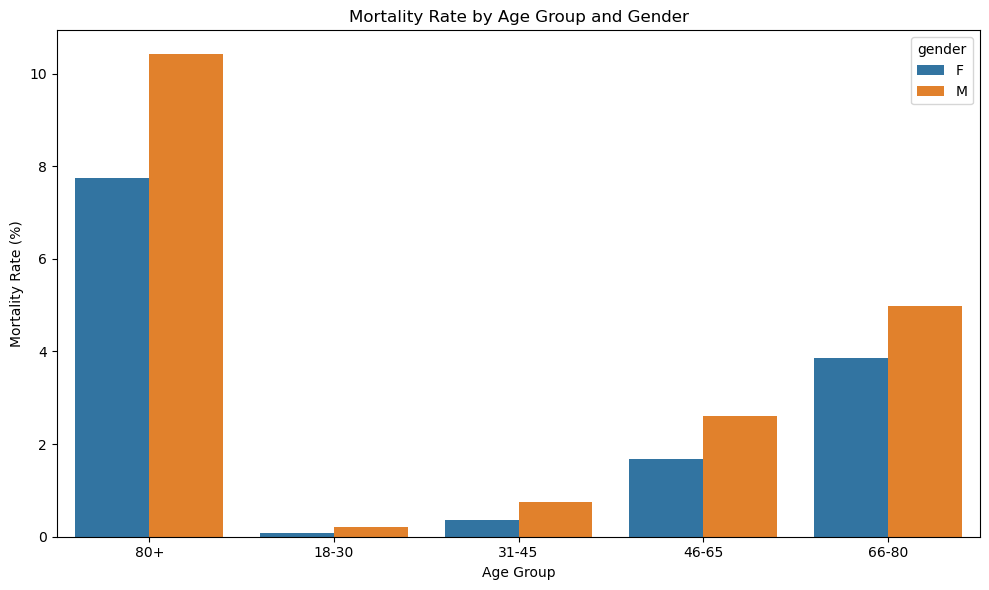

In [36]:
# Race and gender intersection
race_gender_mortality = data.groupby(['race_standard', 'gender'])['died_within_30_days'].mean() * 100
print("Mortality rates by race and gender:")
print(race_gender_mortality.unstack())

# Age and gender intersection
age_gender_mortality = data.groupby(['age_group', 'gender'])['died_within_30_days'].mean() * 100
# Reorder by age group
age_gender_df = age_gender_mortality.unstack().reset_index()
age_gender_df['age_group'] = pd.Categorical(age_gender_df['age_group'], categories=age_order, ordered=True)
age_gender_df = age_gender_df.sort_values('age_group').set_index('age_group')
print("\nMortality rates by age and gender:")
print(age_gender_df)

# Visualize intersections
# Race and gender
plt.figure(figsize=(12, 6))
race_gender_df = race_gender_mortality.reset_index()
sns.barplot(x='race_standard', y='died_within_30_days', hue='gender', data=race_gender_df)
plt.title('Mortality Rate by Race and Gender')
plt.xlabel('Race')
plt.ylabel('Mortality Rate (%)')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# Age and gender
plt.figure(figsize=(10, 6))
age_gender_plot_df = age_gender_mortality.reset_index()
age_gender_plot_df['age_group'] = pd.Categorical(age_gender_plot_df['age_group'], categories=age_order, ordered=True)
age_gender_plot_df = age_gender_plot_df.sort_values('age_group')
sns.barplot(x='age_group', y='died_within_30_days', hue='gender', data=age_gender_plot_df)
plt.title('Mortality Rate by Age Group and Gender')
plt.xlabel('Age Group')
plt.ylabel('Mortality Rate (%)')
plt.tight_layout()
plt.show()

race_standard  American Indian/Alaska Native  Asian  Black  Hispanic/Latino  \
gender                                                                        
F                                   3.21e-03   0.01   0.01         6.58e-03   
M                                   1.28e-02   0.04   0.02         1.32e-02   

race_standard  Multiple Races  Native Hawaiian/Pacific Islander  \
gender                                                            
F                         0.0                              0.02   
M                         0.0                              0.08   

race_standard  Other/Unknown/Not Reported  White  
gender                                            
F                                    0.02   0.02  
M                                    0.04   0.03  


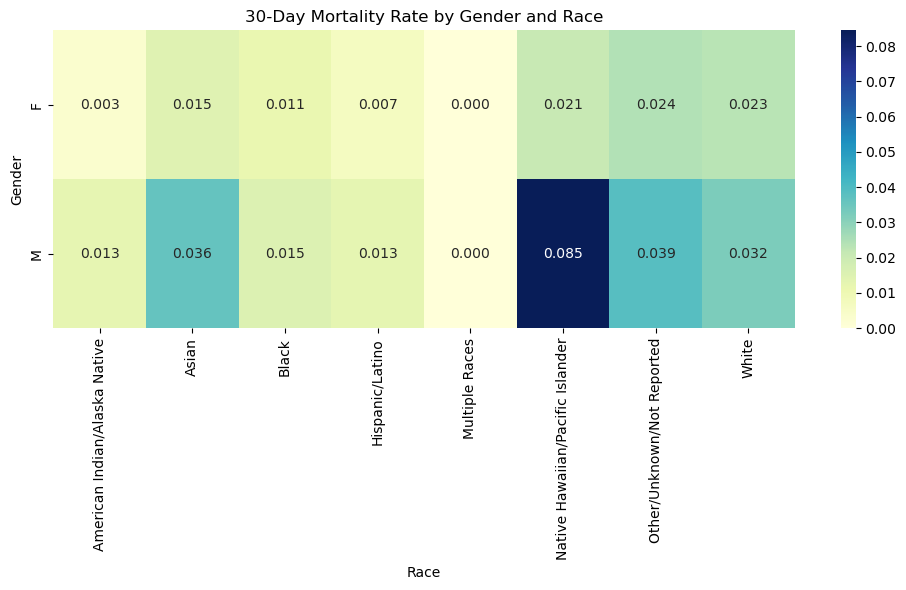

In [37]:
import seaborn as sns
import matplotlib.pyplot as plt
# Step 6: Cross-Fairness Check (Intersectional)

intersection = data.groupby(["gender", "race_standard"])["died_within_30_days"].mean().unstack()
print(intersection)


data.groupby(["gender", "race_standard"])["died_within_30_days"].mean()

plt.figure(figsize=(10, 6))
sns.heatmap(intersection, annot=True, fmt=".3f", cmap="YlGnBu")
plt.title("30-Day Mortality Rate by Gender and Race")
plt.ylabel("Gender")
plt.xlabel("Race")
plt.tight_layout()
plt.show()


30-Day Mortality Rate (%) by Gender and Race:


race_standard,American Indian/Alaska Native,Asian,Black,Hispanic/Latino,Multiple Races,Native Hawaiian/Pacific Islander,Other/Unknown/Not Reported,White
gender,,,,,,,,
F,0.32%,1.46%,1.14%,0.66%,0.00%,2.10%,2.43%,2.32%
M,1.28%,3.63%,1.53%,1.32%,0.00%,8.45%,3.85%,3.23%
M-F Diff,0.96%,2.18%,0.39%,0.66%,0.00%,6.35%,1.42%,0.90%



Formatted Mortality Rate Table (%):
race_standard  American Indian/Alaska Native  Asian  Black  Hispanic/Latino  \
gender                                                                        
F                                       0.32   1.46   1.14             0.66   
M                                       1.28   3.63   1.53             1.32   
M-F Diff                                0.96   2.18   0.39             0.66   

race_standard  Multiple Races  Native Hawaiian/Pacific Islander  \
gender                                                            
F                         0.0                              2.10   
M                         0.0                              8.45   
M-F Diff                  0.0                              6.35   

race_standard  Other/Unknown/Not Reported  White  
gender                                            
F                                    2.43   2.32  
M                                    3.85   3.23  
M-F Diff                   

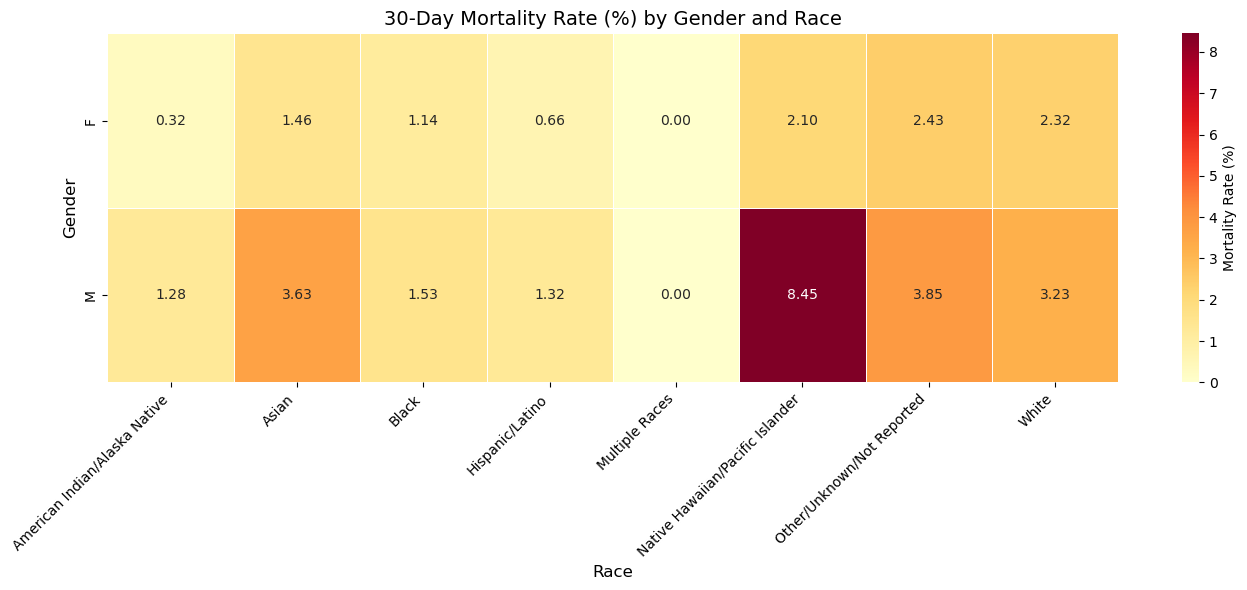

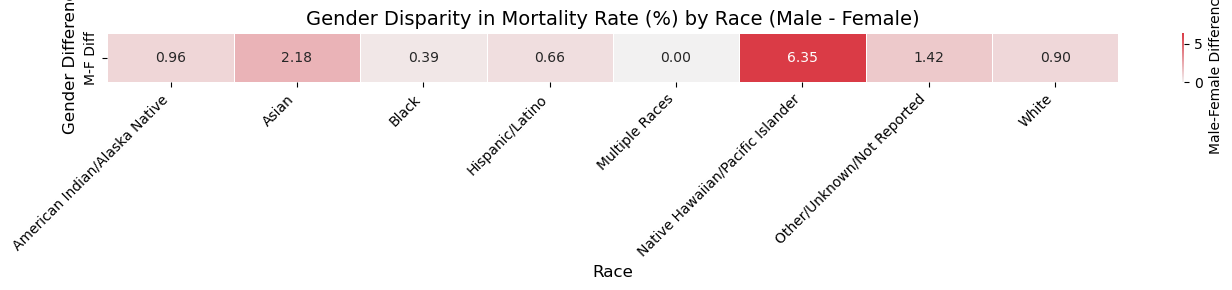

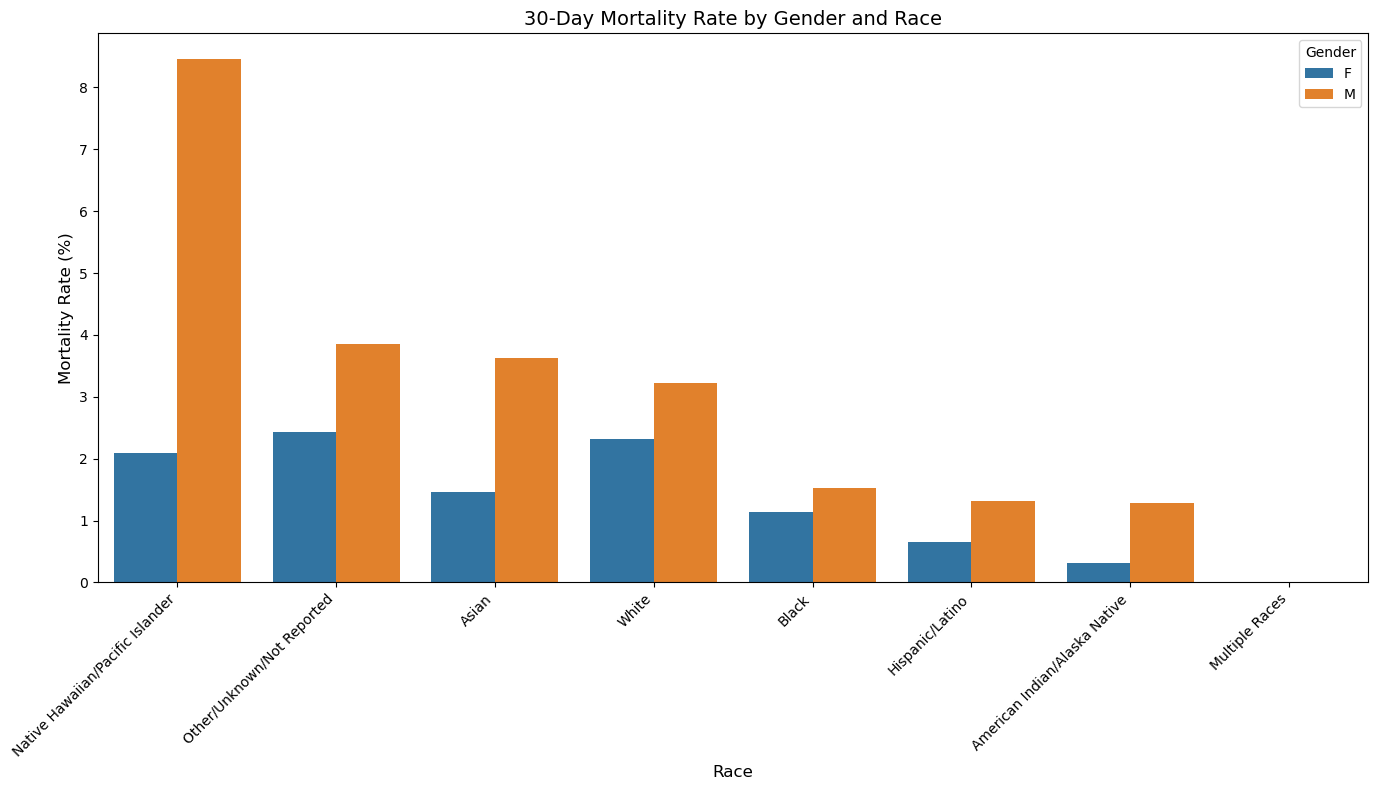

In [38]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Step 6: Cross-Fairness Check (Intersectional)
# Calculate mortality rates by gender and race
intersection = data.groupby(["gender", "race_standard"])["died_within_30_days"].mean().unstack()

# Convert to percentage for better readability
intersection_percent = intersection * 100

# Add row for gender difference (M-F) to highlight gender disparities within races
if 'M' in intersection_percent.index and 'F' in intersection_percent.index:
    gender_diff = intersection_percent.loc['M'] - intersection_percent.loc['F']
    intersection_percent.loc['M-F Diff'] = gender_diff

# Create a styled DataFrame for display
styled_table = intersection_percent.style.format("{:.2f}%")

# Apply conditional formatting (highlight high values)
styled_table = styled_table.background_gradient(cmap='YlOrRd', axis=None)

# Display the styled table
print("30-Day Mortality Rate (%) by Gender and Race:")
display(styled_table)  # This works in Jupyter notebooks

# For non-Jupyter environments, print a formatted version
print("\nFormatted Mortality Rate Table (%):")
pd.set_option('display.precision', 2)  # Set precision for better readability
print(intersection_percent)

# Create improved heatmap visualization
plt.figure(figsize=(14, 6))

# Use a more color-blind friendly colormap
sns.heatmap(intersection_percent.iloc[:-1] if 'M-F Diff' in intersection_percent.index else intersection_percent, 
            annot=True, 
            fmt=".2f", 
            cmap="YlOrRd",
            linewidths=.5,
            cbar_kws={'label': 'Mortality Rate (%)'})

plt.title("30-Day Mortality Rate (%) by Gender and Race", fontsize=14)
plt.ylabel("Gender", fontsize=12)
plt.xlabel("Race", fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# Create a separate heatmap for gender differences if available
if 'M-F Diff' in intersection_percent.index:
    plt.figure(figsize=(14, 3))
    diff_data = pd.DataFrame(intersection_percent.loc['M-F Diff']).T
    
    # Create a diverging colormap centered at zero
    cmap = sns.diverging_palette(240, 10, as_cmap=True)
    
    sns.heatmap(diff_data, 
                annot=True, 
                fmt=".2f", 
                cmap=cmap,
                center=0,
                linewidths=.5,
                cbar_kws={'label': 'Male-Female Difference (%)'})
    
    plt.title("Gender Disparity in Mortality Rate (%) by Race (Male - Female)", fontsize=14)
    plt.ylabel("Gender Difference", fontsize=12)
    plt.xlabel("Race", fontsize=12)
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

# Create a bar chart for better comparison
plt.figure(figsize=(14, 8))

# Reshape data for plotting
plot_data = intersection_percent.reset_index().melt(
    id_vars='gender', 
    var_name='Race', 
    value_name='Mortality Rate (%)'
)

# Remove the gender difference row for bar chart
if 'M-F Diff' in intersection_percent.index:
    plot_data = plot_data[plot_data['gender'] != 'M-F Diff']

# Sort by largest disparity for better visualization
race_order = intersection_percent.mean().sort_values(ascending=False).index
plot_data['Race'] = pd.Categorical(plot_data['Race'], categories=race_order, ordered=True)
plot_data = plot_data.sort_values('Race')

# Create the barplot
sns.barplot(x='Race', y='Mortality Rate (%)', hue='gender', data=plot_data)
plt.title('30-Day Mortality Rate by Gender and Race', fontsize=14)
plt.xlabel('Race', fontsize=12)
plt.ylabel('Mortality Rate (%)', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.legend(title='Gender')
plt.tight_layout()
plt.show()

In [39]:
# Create complaint length feature
data['complaint_len'] = data['chiefcomplaint_cleaned'].apply(
    lambda x: len(eval(x)) if isinstance(x, str) else 0
)

# Check for demographic differences in features
numeric_features = ['anchor_age', 'follow_up_days', 'complaint_len']

# Summary statistics by gender
for feature in numeric_features:
    print(f"\n{feature} by gender:")
    print(data.groupby('gender')[feature].agg(['mean', 'median', 'std']))
    
    # T-test
    male_values = data[data['gender'] == 'M'][feature].dropna()
    female_values = data[data['gender'] == 'F'][feature].dropna()
    t_stat, p_val = stats.ttest_ind(male_values, female_values, equal_var=False)
    print(f"T-test: t = {t_stat:.4f}, p = {p_val:.8f}")
    print(f"Significant difference: {p_val < 0.05}")

# Common chief complaints by demographic (potential proxy variables)
print("\nTop 20 chief complaints by gender:")
for gender in data['gender'].unique():
    complaints = data[data['gender'] == gender]['chiefcomplaint'].value_counts().head(20)
    print(f"\n{gender}:")
    print(complaints)

print("\nTop 20 chief complaints by race (top 3 races):")
top_races = race_counts.index[:3]
for race in top_races:
    complaints = data[data['race_standard'] == race]['chiefcomplaint'].value_counts().head(20)
    print(f"\n{race}:")
    print(complaints)

KeyError: 'chiefcomplaint_cleaned'

In [41]:
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler

# Sample for performance
np.random.seed(42)
sample_size = 5000
sample_indices = np.random.choice(len(data), sample_size, replace=False)
sampled_data = data.iloc[sample_indices].copy()

# Prepare features
features = ['anchor_age', 'complaint_len']
categorical_features = ['gender', 'race_standard']

# One-hot encode categorical features
encoded = pd.get_dummies(sampled_data[categorical_features])

# Combine with numeric features
combined_features = pd.concat([sampled_data[features], encoded], axis=1)

# Scale features
scaler = StandardScaler()
scaled_features = scaler.fit_transform(combined_features)

# Apply t-SNE
tsne = TSNE(n_components=2, perplexity=30, random_state=42)
tsne_result = tsne.fit_transform(scaled_features)

# Create dataframe for plotting
tsne_df = pd.DataFrame(tsne_result, columns=['TSNE1', 'TSNE2'])
tsne_df['gender'] = sampled_data['gender'].values
tsne_df['race'] = sampled_data['race_standard'].values
tsne_df['died'] = sampled_data['died_within_30_days'].values

# Plot by gender
plt.figure(figsize=(10, 8))
sns.scatterplot(x='TSNE1', y='TSNE2', hue='gender', data=tsne_df, alpha=0.6)
plt.title('t-SNE Visualization by Gender')
plt.show()

# Plot by outcome
plt.figure(figsize=(10, 8))
sns.scatterplot(x='TSNE1', y='TSNE2', hue='died', data=tsne_df, 
                palette={1: 'red', 0: 'blue'}, alpha=0.6)
plt.title('t-SNE Visualization by Mortality')
plt.show()

KeyError: "['complaint_len'] not in index"

In [ ]:
# Plot by race
plt.figure(figsize=(12, 10))  # Larger size to accommodate the legend
sns.scatterplot(x='TSNE1', y='TSNE2', hue='race', data=tsne_df, alpha=0.6)
plt.title('t-SNE Visualization by Race')

# Move the legend outside the plot for better visibility
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

In [ ]:
# Check missing data patterns by demographic group
print("Missing data analysis:")

# Missing data by gender
missing_by_gender = data.groupby('gender').apply(
    lambda x: x.isnull().mean() * 100
).T.sort_values(by='M', ascending=False)
print("\nMissing data percentage by gender:")
print(missing_by_gender.head(10))  # Top 10 columns with missing data

# Missing data by race
missing_by_race = data.groupby('race_standard').apply(
    lambda x: x.isnull().mean() * 100
).T
print("\nMissing data percentage by race (selected columns):")
# Select columns with significant missing data
cols_with_missing = data.columns[data.isnull().mean() > 0.05]
print(missing_by_race.loc[cols_with_missing])

In [ ]:

# Sample for performance
np.random.seed(42)
sample_size = 5000
sample_indices = np.random.choice(len(data), sample_size, replace=False)
sampled_data = data.iloc[sample_indices].copy()

# Prepare features
features = ['anchor_age', 'complaint_len']
categorical_features = ['gender', 'race_standard']

# One-hot encode categorical features
encoded = pd.get_dummies(sampled_data[categorical_features])

# Combine with numeric features
combined_features = pd.concat([sampled_data[features], encoded], axis=1)

# Scale features
scaler = StandardScaler()
scaled_features = scaler.fit_transform(combined_features)

# Apply t-SNE
tsne = TSNE(n_components=2, perplexity=30, random_state=42)
tsne_result = tsne.fit_transform(scaled_features)

# Create dataframe for plotting
tsne_df = pd.DataFrame(tsne_result, columns=['TSNE1', 'TSNE2'])
tsne_df['gender'] = sampled_data['gender'].values
tsne_df['race'] = sampled_data['race_standard'].values
tsne_df['died'] = sampled_data['died_within_30_days'].values

# Plot with clear visual differences
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Plot by gender with distinct colors
sns.scatterplot(x='TSNE1', y='TSNE2', hue='gender', data=tsne_df, 
                alpha=0.7, palette={"M": "blue", "F": "red"}, ax=axes[0])
axes[0].set_title('t-SNE Visualization by Gender')
axes[0].legend(title='Gender')

# Plot by race with distinct color palette
sns.scatterplot(x='TSNE1', y='TSNE2', hue='race', data=tsne_df, 
                alpha=0.7, palette='tab10', ax=axes[1])
axes[1].set_title('t-SNE Visualization by Race')
axes[1].legend(title='Race', bbox_to_anchor=(1.05, 1), loc='upper left')

# Plot by mortality
sns.scatterplot(x='TSNE1', y='TSNE2', hue='died', data=tsne_df, 
                alpha=0.7, palette={1: "darkred", 0: "lightblue"}, ax=axes[2])
axes[2].set_title('t-SNE Visualization by Mortality')
axes[2].legend(title='Died', labels=['Survived', 'Died'])

plt.tight_layout()
plt.show()

# Alternative: Create separate plots focused on top races
top_races = sampled_data['race_standard'].value_counts().nlargest(5).index
race_subset = tsne_df[tsne_df['race'].isin(top_races)].copy()

plt.figure(figsize=(10, 8))
sns.scatterplot(x='TSNE1', y='TSNE2', hue='race', data=race_subset, 
                alpha=0.7, palette='Set1', s=60)  # Larger point size
plt.title('t-SNE Visualization by Top 5 Race Groups')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

In [ ]:
from cuml.manifold import TSNE

In [ ]:
# Step 1: Prepare the data - extract the first complaint for simplicity
# (since chiefcomplaint_cleaned is a list in string format)
print("Preparing chief complaint data...")

def extract_first_complaint(complaint_str):
    try:
        # Convert string representation of list to actual list and get first item
        complaints = eval(complaint_str)
        return complaints[0] if complaints else "unknown"
    except:
        return "unknown"

# Apply the function to create a new column with the primary complaint
data['primary_complaint'] = data['chiefcomplaint_cleaned'].apply(extract_first_complaint)

# Step 2: Get the top complaints for analysis (to avoid having too many categories)
top_complaints = data['primary_complaint'].value_counts().head(15).index.tolist()
print(f"Analyzing top {len(top_complaints)} complaints:")
print(top_complaints)

# Step 3: Gender-Chief Complaint Analysis
print("\n--- Gender-Chief Complaint Analysis ---")

# Create a DataFrame for the gender-complaint relationship
gender_complaint_mortality = data[data['primary_complaint'].isin(top_complaints)].groupby(
    ['gender', 'primary_complaint'])['died_within_30_days'].agg(['mean', 'count']).reset_index()

# Rename columns for clarity
gender_complaint_mortality.columns = ['Gender', 'Chief_Complaint', 'Mortality_Rate', 'Patient_Count']

# Convert mortality rate to percentage
gender_complaint_mortality['Mortality_Rate'] = gender_complaint_mortality['Mortality_Rate'] * 100

# Pivot for easier comparison
gender_complaint_pivot = gender_complaint_mortality.pivot(
    index='Chief_Complaint', columns='Gender', values='Mortality_Rate')

# Calculate the difference (M - F)
gender_complaint_pivot['Difference'] = gender_complaint_pivot['M'] - gender_complaint_pivot['F']

# Sort by the absolute difference
gender_complaint_pivot = gender_complaint_pivot.reindex(
    gender_complaint_pivot['Difference'].abs().sort_values(ascending=False).index)

print("Mortality rate (%) by gender and chief complaint:")
print(gender_complaint_pivot)

# Visualization 1: Bar chart comparing mortality rates by gender for each complaint
plt.figure(figsize=(14, 8))
# Reshape data for seaborn
plot_data = gender_complaint_mortality.copy()
# Sort by largest gender gap
complaint_order = gender_complaint_pivot.index.tolist()
plot_data['Chief_Complaint'] = pd.Categorical(
    plot_data['Chief_Complaint'], categories=complaint_order, ordered=True)
plot_data = plot_data.sort_values('Chief_Complaint')

# Create the grouped bar chart
sns.barplot(x='Chief_Complaint', y='Mortality_Rate', hue='Gender', data=plot_data)
plt.title('30-Day Mortality Rate by Gender and Chief Complaint')
plt.xlabel('Chief Complaint')
plt.ylabel('Mortality Rate (%)')
plt.xticks(rotation=45, ha='right')
plt.legend(title='Gender')
plt.tight_layout()
plt.show()

# Visualization 2: Heatmap of mortality rates
plt.figure(figsize=(14, 8))
sns.heatmap(gender_complaint_pivot[['F', 'M']], annot=True, fmt='.2f', cmap='YlOrRd')
plt.title('Mortality Rate (%) by Gender and Chief Complaint')
plt.ylabel('Chief Complaint')
plt.tight_layout()
plt.show()

# Step 4: Race-Chief Complaint Analysis
print("\n--- Race-Chief Complaint Analysis ---")

# Select top races to avoid too many categories
top_races = data['race_standard'].value_counts().head(5).index.tolist()
print(f"Analyzing top {len(top_races)} races:")
print(top_races)

# Create a DataFrame for the race-complaint relationship
race_complaint_mortality = data[
    (data['primary_complaint'].isin(top_complaints)) & 
    (data['race_standard'].isin(top_races))
].groupby(['race_standard', 'primary_complaint'])['died_within_30_days'].agg(['mean', 'count']).reset_index()

# Rename columns for clarity
race_complaint_mortality.columns = ['Race', 'Chief_Complaint', 'Mortality_Rate', 'Patient_Count']

# Convert mortality rate to percentage
race_complaint_mortality['Mortality_Rate'] = race_complaint_mortality['Mortality_Rate'] * 100

# Pivot for easier comparison
race_complaint_pivot = race_complaint_mortality.pivot(
    index='Chief_Complaint', columns='Race', values='Mortality_Rate')

# Calculate max difference between any races for each complaint
race_complaint_pivot['Max_Difference'] = race_complaint_pivot.max(axis=1) - race_complaint_pivot.min(axis=1)

# Sort by the maximum difference
race_complaint_pivot = race_complaint_pivot.reindex(
    race_complaint_pivot['Max_Difference'].sort_values(ascending=False).index)

print("Mortality rate (%) by race and chief complaint:")
print(race_complaint_pivot)

# Visualization 3: Heatmap of mortality rates by race and complaint
plt.figure(figsize=(16, 10))
# Drop the Max_Difference column for the heatmap
heatmap_data = race_complaint_pivot.drop('Max_Difference', axis=1)
sns.heatmap(heatmap_data, annot=True, fmt='.2f', cmap='YlOrRd')
plt.title('Mortality Rate (%) by Race and Chief Complaint')
plt.ylabel('Chief Complaint')
plt.tight_layout()
plt.show()

# Visualization 4: Bar chart for complaints with largest racial disparity
top_disparity_complaints = race_complaint_pivot.head(8).index.tolist()
race_top_disparity = race_complaint_mortality[
    race_complaint_mortality['Chief_Complaint'].isin(top_disparity_complaints)]

plt.figure(figsize=(16, 10))
# Create categorical ordering based on disparity
race_top_disparity['Chief_Complaint'] = pd.Categorical(
    race_top_disparity['Chief_Complaint'], categories=top_disparity_complaints, ordered=True)
race_top_disparity = race_top_disparity.sort_values('Chief_Complaint')

# Create the grouped bar chart
sns.barplot(x='Chief_Complaint', y='Mortality_Rate', hue='Race', data=race_top_disparity)
plt.title('30-Day Mortality Rate by Race and Chief Complaint\n(Complaints with Largest Racial Disparities)')
plt.xlabel('Chief Complaint')
plt.ylabel('Mortality Rate (%)')
plt.xticks(rotation=45, ha='right')
plt.legend(title='Race', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

# Visualization 5: Statistical testing for significant differences
print("\n--- Statistical Testing for Demographic Differences ---")

from scipy.stats import chi2_contingency

# Test for each top complaint whether gender is associated with mortality
print("Chi-square tests for gender-mortality association by complaint:")
for complaint in top_complaints:
    subset = data[data['primary_complaint'] == complaint]
    # Create contingency table: rows=gender, columns=outcome
    contingency = pd.crosstab(subset['gender'], subset['died_within_30_days'])
    
    # Only perform test if we have sufficient data
    if contingency.shape == (2, 2) and contingency.min().min() >= 5:
        chi2, p, _, _ = chi2_contingency(contingency)
        print(f"{complaint}: Chi2 = {chi2:.2f}, p-value = {p:.4f}, " + 
              f"Significant: {p < 0.05}")
    else:
        print(f"{complaint}: Insufficient data for reliable testing")

# Test for each top complaint whether race is associated with mortality
print("\nChi-square tests for race-mortality association by complaint:")
for complaint in top_complaints:
    subset = data[data['primary_complaint'] == complaint]
    # Create contingency table: rows=race, columns=outcome
    contingency = pd.crosstab(subset['race_standard'], subset['died_within_30_days'])
    
    # Only perform test if we have sufficient data
    if contingency.shape[0] >= 2 and contingency.shape[1] == 2 and contingency.min().min() >= 5:
        chi2, p, _, _ = chi2_contingency(contingency)
        print(f"{complaint}: Chi2 = {chi2:.2f}, p-value = {p:.4f}, " + 
              f"Significant: {p < 0.05}")
    else:
        print(f"{complaint}: Insufficient data for reliable testing")

# Visualization 6: Patient count by chief complaint and gender/race
# This helps assess if sample sizes are sufficient for reliable mortality estimates
plt.figure(figsize=(14, 8))
# Patient count by gender and complaint
gender_counts = gender_complaint_mortality.pivot(
    index='Chief_Complaint', columns='Gender', values='Patient_Count')
gender_counts = gender_counts.reindex(complaint_order)
gender_counts.plot(kind='bar', figsize=(14, 6))
plt.title('Patient Count by Gender and Chief Complaint')
plt.xlabel('Chief Complaint')
plt.ylabel('Number of Patients')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# Patient count by race and complaint
plt.figure(figsize=(14, 8))
race_counts = race_complaint_mortality.pivot(
    index='Chief_Complaint', columns='Race', values='Patient_Count')
race_counts = race_counts.reindex(race_complaint_pivot.index)
race_counts.plot(kind='bar', figsize=(16, 8))
plt.title('Patient Count by Race and Chief Complaint')
plt.xlabel('Chief Complaint')
plt.ylabel('Number of Patients')
plt.xticks(rotation=45, ha='right')
plt.legend(title='Race', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

In [ ]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import time

# Start timing
start_time = time.time()

# Step 1: Prepare features (use only numeric features for efficiency)
print("Preparing features...")
features = ['anchor_age']
# Add complaint_len if you have it
if 'complaint_len' not in data.columns:
    data['complaint_len'] = data['chiefcomplaint_cleaned'].apply(
        lambda x: len(eval(x)) if isinstance(x, str) else 0
    )
features.append('complaint_len')

# Step 2: Take a stratified sample (better representation than random)
print("Taking stratified sample...")
# Use a stratified sampling approach based on key attributes
stratify_cols = ['gender', 'race_standard', 'died_within_30_days']
sample_size = 50000  # Adjust based on your computer's capabilities

# Create a combined stratification column
data['strat_group'] = data[stratify_cols].apply(lambda x: '_'.join(x.astype(str)), axis=1)
unique_groups = data['strat_group'].unique()
sampled_indices = []

# Get indices for each group, proportional to their size
for group in unique_groups:
    group_indices = data[data['strat_group'] == group].index.tolist()
    # Calculate how many to sample from this group
    n_to_sample = max(1, int(len(group_indices) / len(data) * sample_size))
    # Sample without replacement if possible
    if len(group_indices) > n_to_sample:
        sampled_from_group = np.random.choice(group_indices, n_to_sample, replace=False)
    else:
        sampled_from_group = group_indices
    sampled_indices.extend(sampled_from_group)

# Limit to desired sample size
if len(sampled_indices) > sample_size:
    sampled_indices = np.random.choice(sampled_indices, sample_size, replace=False)

# Extract the sampled data
sampled_data = data.loc[sampled_indices].copy()
print(f"Sampled {len(sampled_data)} records")

# Step 3: First reduce dimensions with PCA (much faster)
print("Performing PCA...")
X = sampled_data[features].fillna(0)  # Fill missing values
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

pca = PCA(n_components=50)  # Reduce to 50 dimensions first
X_pca = pca.fit_transform(X_scaled)
print(f"Reduced dimensions from {X_scaled.shape[1]} to {X_pca.shape[1]}")

# Step 4: Apply t-SNE on the PCA results (much faster than direct t-SNE)
print("Performing t-SNE...")
tsne = TSNE(n_components=2, perplexity=40, n_iter=1000, random_state=42)
tsne_result = tsne.fit_transform(X_pca)

# Create dataframe for plotting
tsne_df = pd.DataFrame(tsne_result, columns=['TSNE1', 'TSNE2'])
tsne_df['gender'] = sampled_data['gender'].values
tsne_df['race'] = sampled_data['race_standard'].values
tsne_df['died'] = sampled_data['died_within_30_days'].values

# End timing
end_time = time.time()
print(f"Total processing time: {end_time - start_time:.2f} seconds")

# Create plots with better visual separation
plt.figure(figsize=(10, 8))
sns.scatterplot(x='TSNE1', y='TSNE2', hue='gender', data=tsne_df, 
                alpha=0.7, palette={"M": "blue", "F": "red"}, s=15)
plt.title('t-SNE Visualization by Gender')
plt.legend(title='Gender')
plt.show()

plt.figure(figsize=(10, 8))
sns.scatterplot(x='TSNE1', y='TSNE2', hue='died', data=tsne_df,
                alpha=0.7, palette={1: "red", 0: "grey"}, s=15)
plt.title('t-SNE Visualization by Mortality')
plt.legend(title='Died within 30 days')
plt.show()

# For race, focus on top races for better visualization
top_races = sampled_data['race_standard'].value_counts().nlargest(5).index
race_subset = tsne_df[tsne_df['race'].isin(top_races)].copy()

plt.figure(figsize=(12, 10))
sns.scatterplot(x='TSNE1', y='TSNE2', hue='race', data=race_subset,
                alpha=0.7, palette='Set1', s=15)
plt.title('t-SNE Visualization by Race (Top 5)')
plt.legend(title='Race', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

# Extract the primary complaint or diagnosis
print("Analyzing mortality by primary complaint...")

# Using the primary complaint from chiefcomplaint_cleaned
if 'primary_complaint' not in data.columns:
    def extract_first_complaint(complaint_str):
        try:
            complaints = eval(complaint_str)
            return complaints[0] if complaints else "unknown"
        except:
            return "unknown"
    
    data['primary_complaint'] = data['chiefcomplaint_cleaned'].apply(extract_first_complaint)

# Get top complaints by frequency
top_complaints = data['primary_complaint'].value_counts().head(15).index.tolist()

# Create a DataFrame with mortality rates by gender and complaint
mortality_by_gender_complaint = data[data['primary_complaint'].isin(top_complaints)].groupby(
    ['gender', 'primary_complaint'])['died_within_30_days'].agg(['mean', 'count']).reset_index()

# Rename columns and convert to percentage
mortality_by_gender_complaint.columns = ['Gender', 'Complaint', 'Mortality_Rate', 'Count']
mortality_by_gender_complaint['Mortality_Rate'] = mortality_by_gender_complaint['Mortality_Rate'] * 100

# Create a pivot table for easier comparison
gender_complaint_table = mortality_by_gender_complaint.pivot(
    index='Complaint', columns='Gender', values=['Mortality_Rate', 'Count'])

# Calculate the gender difference and sort by it
if ('Mortality_Rate', 'M') in gender_complaint_table.columns and ('Mortality_Rate', 'F') in gender_complaint_table.columns:
    gender_complaint_table[('Mortality_Rate', 'Diff')] = gender_complaint_table[('Mortality_Rate', 'M')] - gender_complaint_table[('Mortality_Rate', 'F')]
    gender_complaint_table = gender_complaint_table.sort_values(('Mortality_Rate', 'Diff'), ascending=False)

# Display the formatted table
print("\nMortality Rates (%) by Gender and Complaint:")
print(gender_complaint_table)

# Visualize with a grouped bar chart
plt.figure(figsize=(14, 8))
complaint_order = gender_complaint_table.index.tolist()
plot_data = mortality_by_gender_complaint.copy()
plot_data['Complaint'] = pd.Categorical(plot_data['Complaint'], categories=complaint_order, ordered=True)
plot_data = plot_data.sort_values('Complaint')

sns.barplot(x='Complaint', y='Mortality_Rate', hue='Gender', data=plot_data)
plt.title('30-Day Mortality Rate by Gender and Chief Complaint')
plt.xlabel('Chief Complaint')
plt.ylabel('Mortality Rate (%)')
plt.xticks(rotation=45, ha='right')
plt.legend(title='Gender')
plt.tight_layout()
plt.show()

# Similar analysis for race
print("\nAnalyzing mortality by race and complaint...")
top_races = data['race_standard'].value_counts().head(5).index.tolist()
mortality_by_race_complaint = data[
    (data['primary_complaint'].isin(top_complaints)) & 
    (data['race_standard'].isin(top_races))
].groupby(['race_standard', 'primary_complaint'])['died_within_30_days'].agg(['mean', 'count']).reset_index()

mortality_by_race_complaint.columns = ['Race', 'Complaint', 'Mortality_Rate', 'Count']
mortality_by_race_complaint['Mortality_Rate'] = mortality_by_race_complaint['Mortality_Rate'] * 100

# Visualize with heatmap for better readability with many race categories
race_complaint_pivot = mortality_by_race_complaint.pivot(
    index='Complaint', columns='Race', values='Mortality_Rate')

plt.figure(figsize=(14, 10))
sns.heatmap(race_complaint_pivot, annot=True, fmt='.2f', cmap='YlOrRd')
plt.title('Mortality Rate (%) by Race and Chief Complaint')
plt.ylabel('Chief Complaint')
plt.tight_layout()
plt.show()

In [ ]:
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import time

# Start timing
start_time = time.time()

# Filter to only patients who died within 30 days
deceased_patients = data[data['died_within_30_days'] == 1].copy()
print(f"Analyzing {len(deceased_patients)} deceased patients")

# Prepare features
features = ['anchor_age', 'complaint_len']  # Make sure these exist
categorical_features = ['gender', 'race_standard']

# One-hot encode categorical features
encoded = pd.get_dummies(deceased_patients[categorical_features])

# Combine with numeric features
combined_features = pd.concat([deceased_patients[features], encoded], axis=1)

# Scale features
scaler = StandardScaler()
scaled_features = scaler.fit_transform(combined_features)

# Apply t-SNE
print("Running t-SNE...")
tsne = TSNE(n_components=2, perplexity=30, random_state=42)
tsne_result = tsne.fit_transform(scaled_features)

# End timing
end_time = time.time()
print(f"t-SNE completed in {end_time - start_time:.2f} seconds")

# Create dataframe for plotting
tsne_df = pd.DataFrame(tsne_result, columns=['TSNE1', 'TSNE2'])
tsne_df['gender'] = deceased_patients['gender'].values
tsne_df['race'] = deceased_patients['race_standard'].values

# Plot by gender
plt.figure(figsize=(10, 8))
sns.scatterplot(x='TSNE1', y='TSNE2', hue='gender', data=tsne_df, 
                alpha=0.7, palette={"M": "blue", "F": "red"})
plt.title('t-SNE Visualization of Deceased Patients by Gender')
plt.legend(title='Gender')
plt.show()

# Plot by race (focus on top races)
top_races = deceased_patients['race_standard'].value_counts().nlargest(5).index
race_subset = tsne_df[tsne_df['race'].isin(top_races)].copy()

plt.figure(figsize=(12, 10))
sns.scatterplot(x='TSNE1', y='TSNE2', hue='race', data=race_subset, 
                alpha=0.7, palette='Set1')
plt.title('t-SNE Visualization of Deceased Patients by Race (Top 5)')
plt.legend(title='Race', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

In [ ]:
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import time

# Start timing
start_time = time.time()

# Filter to only patients who died within 30 days
deceased_patients = data[data['died_within_30_days'] == 1].copy()
print(f"Analyzing {len(deceased_patients)} deceased patients")

# Prepare features
features = ['anchor_age', 'complaint_len']  # Make sure these exist
categorical_features = ['gender', 'race_standard', 'age_group']

# One-hot encode categorical features
encoded = pd.get_dummies(deceased_patients[categorical_features])

# Combine with numeric features
combined_features = pd.concat([deceased_patients[features], encoded], axis=1)

# Scale features
scaler = StandardScaler()
scaled_features = scaler.fit_transform(combined_features)

# Apply t-SNE
print("Running t-SNE...")
tsne = TSNE(n_components=2, perplexity=30, random_state=42)
tsne_result = tsne.fit_transform(scaled_features)

# End timing
end_time = time.time()
print(f"t-SNE completed in {end_time - start_time:.2f} seconds")

# Create dataframe for plotting
tsne_df = pd.DataFrame(tsne_result, columns=['TSNE1', 'TSNE2'])
tsne_df['gender'] = deceased_patients['gender'].values
tsne_df['race'] = deceased_patients['race_standard'].values
tsne_df['age_group'] = deceased_patients['age_group'].values

# Plot by gender
plt.figure(figsize=(10, 8))
sns.scatterplot(x='TSNE1', y='TSNE2', hue='gender', data=tsne_df, 
                alpha=0.7, palette={"M": "blue", "F": "red"})
plt.title('t-SNE Visualization of Deceased Patients by Gender')
plt.legend(title='Gender')
plt.show()

# Plot by race (focus on top races)
top_races = deceased_patients['race_standard'].value_counts().nlargest(5).index
race_subset = tsne_df[tsne_df['race'].isin(top_races)].copy()

plt.figure(figsize=(12, 10))
sns.scatterplot(x='TSNE1', y='TSNE2', hue='race', data=race_subset, 
                alpha=0.7, palette='Set1')
plt.title('t-SNE Visualization of Deceased Patients by Race (Top 5)')
plt.legend(title='Race', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

# Plot by age group
plt.figure(figsize=(12, 10))
# Ensure age groups are in logical order if possible
age_order = ["18-30", "31-45", "46-65", "66-80", "80+"]
# Check if these age groups match your data
if set(deceased_patients['age_group'].unique()).issubset(set(age_order)):
    sns.scatterplot(x='TSNE1', y='TSNE2', hue='age_group', data=tsne_df, 
                    alpha=0.7, palette='viridis', hue_order=age_order)
else:
    # If age groups are different, just use the data as is
    sns.scatterplot(x='TSNE1', y='TSNE2', hue='age_group', data=tsne_df, 
                    alpha=0.7, palette='viridis')
plt.title('t-SNE Visualization of Deceased Patients by Age Group')
plt.legend(title='Age Group', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

In [ ]:
# Part 1: Identify top chief complaints and their mortality rates

# Extract primary complaint (if not already done)
if 'primary_complaint' not in data.columns:
    def extract_first_complaint(complaint_str):
        try:
            complaints = eval(complaint_str)
            return complaints[0] if complaints else "unknown"
        except:
            return "unknown"
    
    data['primary_complaint'] = data['chiefcomplaint_cleaned'].apply(extract_first_complaint)

# Get top complaints by frequency
top_complaints = data['primary_complaint'].value_counts().head(15).index.tolist()
print(f"Top 15 chief complaints: {top_complaints}")

# Calculate overall mortality rate for each top complaint
complaint_mortality = data[data['primary_complaint'].isin(top_complaints)].groupby(
    'primary_complaint')['died_within_30_days'].agg(['mean', 'count']).reset_index()
complaint_mortality.columns = ['Chief_Complaint', 'Mortality_Rate', 'Patient_Count']
complaint_mortality['Mortality_Rate'] = complaint_mortality['Mortality_Rate'] * 100
complaint_mortality = complaint_mortality.sort_values('Mortality_Rate', ascending=False)

print("\nMortality rate by chief complaint:")
print(complaint_mortality)

# Part 2: T-SNE visualization of deceased patients with chief complaint information
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
import time

# Filter to only patients who died within 30 days with top complaints
deceased_with_top_complaints = data[(data['died_within_30_days'] == 1) & 
                                    (data['primary_complaint'].isin(top_complaints))].copy()
print(f"\nAnalyzing {len(deceased_with_top_complaints)} deceased patients with top complaints")

# Start timing
start_time = time.time()

# Prepare features
features = ['anchor_age', 'complaint_len']
categorical_features = ['gender', 'race_standard', 'primary_complaint']

# One-hot encode categorical features
encoded = pd.get_dummies(deceased_with_top_complaints[categorical_features])

# Combine with numeric features
combined_features = pd.concat([deceased_with_top_complaints[features], encoded], axis=1)

# Scale features
scaler = StandardScaler()
scaled_features = scaler.fit_transform(combined_features)

# Apply t-SNE
print("Running t-SNE...")
tsne = TSNE(n_components=2, perplexity=30, random_state=42)
tsne_result = tsne.fit_transform(scaled_features)

print(f"t-SNE completed in {time.time() - start_time:.2f} seconds")

# Create dataframe for plotting
tsne_df = pd.DataFrame(tsne_result, columns=['TSNE1', 'TSNE2'])
tsne_df['gender'] = deceased_with_top_complaints['gender'].values
tsne_df['race'] = deceased_with_top_complaints['race_standard'].values
tsne_df['age_group'] = deceased_with_top_complaints['age_group'].values
tsne_df['complaint'] = deceased_with_top_complaints['primary_complaint'].values

# Plot by chief complaint 
plt.figure(figsize=(14, 10))
# Focus on top 8 complaints for better visualization
top_8_complaints = complaint_mortality['Chief_Complaint'].head(8).tolist()
complaint_subset = tsne_df[tsne_df['complaint'].isin(top_8_complaints)].copy()

sns.scatterplot(x='TSNE1', y='TSNE2', hue='complaint', data=complaint_subset, 
                alpha=0.7, palette='tab10')
plt.title('t-SNE Visualization of Deceased Patients by Chief Complaint (Top 8)')
plt.legend(title='Chief Complaint', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

# Part 3: Mortality rates by demographic and chief complaint
print("\n--- Mortality Analysis by Demographics and Chief Complaint ---")

# Gender and chief complaint
gender_complaint_mortality = data[data['primary_complaint'].isin(top_complaints)].groupby(
    ['gender', 'primary_complaint'])['died_within_30_days'].agg(['mean', 'count']).reset_index()
gender_complaint_mortality.columns = ['Gender', 'Chief_Complaint', 'Mortality_Rate', 'Patient_Count']
gender_complaint_mortality['Mortality_Rate'] = gender_complaint_mortality['Mortality_Rate'] * 100

# Pivot for comparison
gender_complaint_pivot = gender_complaint_mortality.pivot(
    index='Chief_Complaint', columns='Gender', values='Mortality_Rate')

# Calculate gender difference
gender_complaint_pivot['M-F_Diff'] = gender_complaint_pivot['M'] - gender_complaint_pivot['F']
gender_complaint_pivot = gender_complaint_pivot.sort_values('M-F_Diff', ascending=False)

print("\nMortality rates by gender and chief complaint:")
print(gender_complaint_pivot)

# Visualize gender differences
plt.figure(figsize=(14, 8))
# Plot data
plot_data = gender_complaint_mortality.copy()
# Sort by gender difference
complaint_order = gender_complaint_pivot.index.tolist()
plot_data['Chief_Complaint'] = pd.Categorical(
    plot_data['Chief_Complaint'], categories=complaint_order, ordered=True)
plot_data = plot_data.sort_values('Chief_Complaint')

sns.barplot(x='Chief_Complaint', y='Mortality_Rate', hue='Gender', data=plot_data)
plt.title('30-Day Mortality Rate by Gender and Chief Complaint')
plt.xlabel('Chief Complaint')
plt.ylabel('Mortality Rate (%)')
plt.xticks(rotation=45, ha='right')
plt.legend(title='Gender')
plt.tight_layout()
plt.show()

# Race and chief complaint analysis
# Select top races 
top_races = data['race_standard'].value_counts().head(4).index.tolist()
race_complaint_mortality = data[
    (data['primary_complaint'].isin(top_complaints)) & 
    (data['race_standard'].isin(top_races))
].groupby(['race_standard', 'primary_complaint'])['died_within_30_days'].agg(['mean', 'count']).reset_index()

race_complaint_mortality.columns = ['Race', 'Chief_Complaint', 'Mortality_Rate', 'Patient_Count']
race_complaint_mortality['Mortality_Rate'] = race_complaint_mortality['Mortality_Rate'] * 100

# Pivot for easier visualization
race_complaint_pivot = race_complaint_mortality.pivot(
    index='Chief_Complaint', columns='Race', values='Mortality_Rate')

# Calculate max difference between races
race_complaint_pivot['Max_Diff'] = race_complaint_pivot.max(axis=1) - race_complaint_pivot.min(axis=1)
race_complaint_pivot = race_complaint_pivot.sort_values('Max_Diff', ascending=False)

print("\nMortality rates by race and chief complaint (top 4 races):")
print(race_complaint_pivot)

# Visualize with heatmap
plt.figure(figsize=(14, 10))
# Drop Max_Diff column for visualization
heatmap_data = race_complaint_pivot.drop('Max_Diff', axis=1)
sns.heatmap(heatmap_data, annot=True, fmt='.2f', cmap='YlOrRd')
plt.title('Mortality Rate (%) by Race and Chief Complaint')
plt.ylabel('Chief Complaint')
plt.tight_layout()
plt.show()

# Age group and chief complaint
age_complaint_mortality = data[data['primary_complaint'].isin(top_complaints)].groupby(
    ['age_group', 'primary_complaint'])['died_within_30_days'].agg(['mean', 'count']).reset_index()
age_complaint_mortality.columns = ['Age_Group', 'Chief_Complaint', 'Mortality_Rate', 'Patient_Count']
age_complaint_mortality['Mortality_Rate'] = age_complaint_mortality['Mortality_Rate'] * 100

# Pivot for comparison
age_complaint_pivot = age_complaint_mortality.pivot(
    index='Chief_Complaint', columns='Age_Group', values='Mortality_Rate')

print("\nMortality rates by age group and chief complaint:")
print(age_complaint_pivot)

# Visualize with heatmap
plt.figure(figsize=(14, 10))
# Ensure age groups are in logical order if possible
age_order = ["18-30", "31-45", "46-65", "66-80", "80+"]
if set(data['age_group'].unique()).issubset(set(age_order)):
    # Reorder columns if age groups match expected format
    ordered_cols = [col for col in age_order if col in age_complaint_pivot.columns]
    sns.heatmap(age_complaint_pivot[ordered_cols], annot=True, fmt='.2f', cmap='YlOrRd')
else:
    sns.heatmap(age_complaint_pivot, annot=True, fmt='.2f', cmap='YlOrRd')
plt.title('Mortality Rate (%) by Age Group and Chief Complaint')
plt.ylabel('Chief Complaint')
plt.tight_layout()
plt.show()

In [ ]:
# Part 1: Identify top chief complaints and their mortality rates

# Extract primary complaint (if not already done)
if 'primary_complaint' not in data.columns:
    def extract_first_complaint(complaint_str):
        try:
            complaints = eval(complaint_str)
            return complaints[0] if complaints else "unknown"
        except:
            return "unknown"
    
    data['primary_complaint'] = data['chiefcomplaint_cleaned'].apply(extract_first_complaint)

# Get top complaints by frequency
top_complaints = data['primary_complaint'].value_counts().head(15).index.tolist()
print(f"Top 15 chief complaints: {top_complaints}")

# Calculate overall mortality rate for each top complaint
complaint_mortality = data[data['primary_complaint'].isin(top_complaints)].groupby(
    'primary_complaint')['died_within_30_days'].agg(['mean', 'count']).reset_index()
complaint_mortality.columns = ['Chief_Complaint', 'Mortality_Rate', 'Patient_Count']
complaint_mortality['Mortality_Rate'] = complaint_mortality['Mortality_Rate'] * 100
complaint_mortality = complaint_mortality.sort_values('Mortality_Rate', ascending=False)

print("\nMortality rate by chief complaint:")
print(complaint_mortality)

# Part 2: T-SNE visualization of deceased patients with chief complaint information
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
import time

# Filter to only patients who died within 30 days with all complaints
deceased_with_top_complaints = data[(data['died_within_30_days'] == 1) & 
                                    (data['primary_complaint'].isin(top_complaints))].copy()
print(f"\nAnalyzing {len(deceased_with_top_complaints)} deceased patients with top complaints")

# Start timing
start_time = time.time()

# Prepare features
features = ['anchor_age', 'complaint_len']
categorical_features = ['gender', 'race_standard', 'primary_complaint']

# One-hot encode categorical features
encoded = pd.get_dummies(deceased_with_top_complaints[categorical_features])

# Combine with numeric features
combined_features = pd.concat([deceased_with_top_complaints[features], encoded], axis=1)

# Scale features
scaler = StandardScaler()
scaled_features = scaler.fit_transform(combined_features)

# Apply t-SNE
print("Running t-SNE...")
tsne = TSNE(n_components=2, perplexity=30, random_state=42)
tsne_result = tsne.fit_transform(scaled_features)

print(f"t-SNE completed in {time.time() - start_time:.2f} seconds")

# Create dataframe for plotting
tsne_df = pd.DataFrame(tsne_result, columns=['TSNE1', 'TSNE2'])
tsne_df['gender'] = deceased_with_top_complaints['gender'].values
tsne_df['race'] = deceased_with_top_complaints['race_standard'].values
tsne_df['age_group'] = deceased_with_top_complaints['age_group'].values
tsne_df['complaint'] = deceased_with_top_complaints['primary_complaint'].values

# Plot by chief complaint 
plt.figure(figsize=(14, 10))
# Focus on top 8 complaints for better visualization
top_8_complaints = complaint_mortality['Chief_Complaint'].head(8).tolist()
complaint_subset = tsne_df[tsne_df['complaint'].isin(top_8_complaints)].copy()

sns.scatterplot(x='TSNE1', y='TSNE2', hue='complaint', data=complaint_subset, 
                alpha=0.7, palette='tab10')
plt.title('t-SNE Visualization of Deceased Patients by Chief Complaint (Top 8)')
plt.legend(title='Chief Complaint', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

# Part 3: Mortality rates by demographic and chief complaint
print("\n--- Mortality Analysis by Demographics and Chief Complaint ---")

# Gender and chief complaint
gender_complaint_mortality = data[data['primary_complaint'].isin(top_complaints)].groupby(
    ['gender', 'primary_complaint'])['died_within_30_days'].agg(['mean', 'count']).reset_index()
gender_complaint_mortality.columns = ['Gender', 'Chief_Complaint', 'Mortality_Rate', 'Patient_Count']
gender_complaint_mortality['Mortality_Rate'] = gender_complaint_mortality['Mortality_Rate'] * 100

# Pivot for comparison
gender_complaint_pivot = gender_complaint_mortality.pivot(
    index='Chief_Complaint', columns='Gender', values='Mortality_Rate')

# Calculate gender difference
gender_complaint_pivot['M-F_Diff'] = gender_complaint_pivot['M'] - gender_complaint_pivot['F']
gender_complaint_pivot = gender_complaint_pivot.sort_values('M-F_Diff', ascending=False)

print("\nMortality rates by gender and chief complaint:")
print(gender_complaint_pivot)

# Visualize gender differences
plt.figure(figsize=(14, 8))
# Plot data
plot_data = gender_complaint_mortality.copy()
# Sort by gender difference
complaint_order = gender_complaint_pivot.index.tolist()
plot_data['Chief_Complaint'] = pd.Categorical(
    plot_data['Chief_Complaint'], categories=complaint_order, ordered=True)
plot_data = plot_data.sort_values('Chief_Complaint')

sns.barplot(x='Chief_Complaint', y='Mortality_Rate', hue='Gender', data=plot_data)
plt.title('30-Day Mortality Rate by Gender and Chief Complaint')
plt.xlabel('Chief Complaint')
plt.ylabel('Mortality Rate (%)')
plt.xticks(rotation=45, ha='right')
plt.legend(title='Gender')
plt.tight_layout()
plt.show()

# Race and chief complaint analysis
# Select top races 
top_races = data['race_standard'].value_counts().head(4).index.tolist()
race_complaint_mortality = data[
    (data['primary_complaint'].isin(top_complaints)) & 
    (data['race_standard'].isin(top_races))
].groupby(['race_standard', 'primary_complaint'])['died_within_30_days'].agg(['mean', 'count']).reset_index()

race_complaint_mortality.columns = ['Race', 'Chief_Complaint', 'Mortality_Rate', 'Patient_Count']
race_complaint_mortality['Mortality_Rate'] = race_complaint_mortality['Mortality_Rate'] * 100

# Pivot for easier visualization
race_complaint_pivot = race_complaint_mortality.pivot(
    index='Chief_Complaint', columns='Race', values='Mortality_Rate')

# Calculate max difference between races
race_complaint_pivot['Max_Diff'] = race_complaint_pivot.max(axis=1) - race_complaint_pivot.min(axis=1)
race_complaint_pivot = race_complaint_pivot.sort_values('Max_Diff', ascending=False)

print("\nMortality rates by race and chief complaint (top 4 races):")
print(race_complaint_pivot)

# Visualize with heatmap
plt.figure(figsize=(14, 10))
# Drop Max_Diff column for visualization
heatmap_data = race_complaint_pivot.drop('Max_Diff', axis=1)
sns.heatmap(heatmap_data, annot=True, fmt='.2f', cmap='YlOrRd')
plt.title('Mortality Rate (%) by Race and Chief Complaint')
plt.ylabel('Chief Complaint')
plt.tight_layout()
plt.show()

# Age group and chief complaint
age_complaint_mortality = data[data['primary_complaint'].isin(top_complaints)].groupby(
    ['age_group', 'primary_complaint'])['died_within_30_days'].agg(['mean', 'count']).reset_index()
age_complaint_mortality.columns = ['Age_Group', 'Chief_Complaint', 'Mortality_Rate', 'Patient_Count']
age_complaint_mortality['Mortality_Rate'] = age_complaint_mortality['Mortality_Rate'] * 100

# Pivot for comparison
age_complaint_pivot = age_complaint_mortality.pivot(
    index='Chief_Complaint', columns='Age_Group', values='Mortality_Rate')

print("\nMortality rates by age group and chief complaint:")
print(age_complaint_pivot)

# Visualize with heatmap
plt.figure(figsize=(14, 10))
# Ensure age groups are in logical order if possible
age_order = ["18-30", "31-45", "46-65", "66-80", "80+"]
if set(data['age_group'].unique()).issubset(set(age_order)):
    # Reorder columns if age groups match expected format
    ordered_cols = [col for col in age_order if col in age_complaint_pivot.columns]
    sns.heatmap(age_complaint_pivot[ordered_cols], annot=True, fmt='.2f', cmap='YlOrRd')
else:
    sns.heatmap(age_complaint_pivot, annot=True, fmt='.2f', cmap='YlOrRd')
plt.title('Mortality Rate (%) by Age Group and Chief Complaint')
plt.ylabel('Chief Complaint')
plt.tight_layout()
plt.show()

In [ ]:
# Summarize findings
print("===== BIAS ANALYSIS SUMMARY =====")

# Gender bias summary
print("\nGENDER BIAS ANALYSIS:")
print(f"- Gender representation: M = {gender_counts['M']/len(data)*100:.1f}%, F = {gender_counts['F']/len(data)*100:.1f}%")
print(f"- Mortality rate: M = {gender_mortality['M']:.2f}%, F = {gender_mortality['F']:.2f}%")
print(f"- Statistical significance: p = {p_gender:.8f} ({'Significant' if p_gender < 0.05 else 'Not significant'})")
print(f"- Statistical parity difference: {gender_spd:.4f}")
print(f"- Disparate impact ratio: {gender_dir:.4f} ({'Potential bias' if gender_dir < 0.8 else 'No major bias'})")

# Race bias summary
print("\nRACE BIAS ANALYSIS:")
print(f"- Largest group: {race_counts.index[0]} = {race_counts.iloc[0]/len(data)*100:.1f}%")
print(f"- Mortality rate range: {race_mortality.min():.2f}% to {race_mortality.max():.2f}%")
print(f"- Statistical significance: p = {p_race:.8f} ({'Significant' if p_race < 0.05 else 'Not significant'})")
print(f"- Statistical parity difference: {race_spd:.4f}")
print(f"- Disparate impact ratio: {race_dir:.4f} ({'Potential bias' if race_dir < 0.8 else 'No major bias'})")

# Age bias summary
print("\nAGE BIAS ANALYSIS:")
print(f"- Largest age group: {age_counts.index[0]} = {age_counts.iloc[0]/len(data)*100:.1f}%")
print(f"- Mortality rate range: {age_mortality.min():.2f}% to {age_mortality.max():.2f}%")
print(f"- Statistical significance: p = {p_age:.8f} ({'Significant' if p_age < 0.05 else 'Not significant'})")
print(f"- Statistical parity difference: {age_spd:.4f}")
print(f"- Disparate impact ratio: {age_dir:.4f} ({'Potential bias' if age_dir < 0.8 else 'No major bias'})")

# Intersectional findings
print("\nINTERSECTIONAL FINDINGS:")
race_gender_table = race_gender_mortality.unstack()
highest_group = race_gender_table.stack().idxmax()
lowest_group = race_gender_table.stack().idxmin()
print(f"- Highest mortality group: {highest_group[0]}/{highest_group[1]} = {race_gender_table.stack().max():.2f}%")
print(f"- Lowest mortality group: {lowest_group[0]}/{lowest_group[1]} = {race_gender_table.stack().min():.2f}%")
print(f"- Max intersection disparity: {race_gender_table.stack().max() - race_gender_table.stack().min():.2f}%")